In [28]:
%load_ext edx_jupyter

The edx_jupyter extension is already loaded. To reload it, use:
  %reload_ext edx_jupyter


In [29]:
%reload_ext edx_jupyter

In [30]:
%%vertica

SELECT 'Connected to Vertica!'

,?column?
0,Connected to Vertica!


In [55]:
%vertica SET TIME ZONE to UTC;

In [56]:
analysis_start_time = '2017-08-16 20:49:00'
analysis_end_time = '2017-08-19 20:49:00'

In [57]:
import pandas as pd
import numpy as np
from plotnine import *
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
%%vertica

select 
    group_name,
    count(*)
from
    neem.pal_experiment_population
group by 1

,group_name,count
0,treatment,3084
1,control,3057


In [59]:
%%vertica (analysis_end_time=analysis_end_time, analysis_start_time=analysis_start_time)
select group_name, SUM(CASE 
                           WHEN course.first_verified_enrollment_time > :analysis_start_time
                           AND course.first_verified_enrollment_time < :analysis_end_time
                           AND course.current_enrollment_mode = 'verified'
                           THEN 1
                           ELSE 0
                        END)*100/COUNT(1)
from neem.pal_experiment_population as pop
    INNER JOIN 
        production.d_user_course as course
    ON pop.user_id = course.user_id
    AND pop.course_id = course.course_id
GROUP by 1

,group_name,?column?
0,treatment,1.523994811932555123
1,control,1.177625122669283611


In [60]:
# Aggregated Data Set for quick look 

In [61]:
%%vertica (analysis_end_time=analysis_end_time,analysis_start_time=analysis_start_time) -> agg_data_set
select group_name, DATEDIFF('day',completed.passed_timestamp,:analysis_start_time) AS 'Days since passing',
                        master.course_seat_price as Price, 
                        SUM(CASE 
                           WHEN course.first_verified_enrollment_time > :analysis_start_time
                           AND course.first_verified_enrollment_time < :analysis_end_time
                           AND course.current_enrollment_mode = 'verified'
                           THEN 1
                           ELSE 0
                        END) AS Verifications,
                        COUNT(1) AS Learners,
                        SUM(CASE 
                           WHEN course.first_verified_enrollment_time > :analysis_start_time
                           AND course.first_verified_enrollment_time < :analysis_end_time
                           AND course.current_enrollment_mode = 'verified'
                           THEN 1
                           ELSE 0
                        END)*100/COUNT(1) AS VTR
        
from neem.pal_experiment_population as pop
    INNER JOIN
    business_intelligence.course_master as master
        ON pop.course_id = master.course_id
    INNER JOIN 
        production.d_user_course as course
        ON pop.user_id = course.user_id
        AND pop.course_id = course.course_id
    INNER JOIN
        business_intelligence.course_completion_user as completed
    ON pop.user_id = completed.user_id
    AND pop.course_id = completed.course_id
GROUP by 1,2,3
ORDER by 2,3

In [62]:
agg_data_set.set_index('group_name', inplace=True)

In [63]:
agg_data_set.head()

,Days since passing,Price,Verifications,Learners,VTR
group_name,,,,,
treatment,1,25.0,0,1,0E-18
control,1,25.0,0,5,0E-18
treatment,1,40.0,0,3,0E-18
treatment,1,49.0,1,10,10.000000000000000000
control,1,49.0,1,10,10.000000000000000000


In [64]:
# Aggregated Data Frame with cert price grouping

In [65]:
%%vertica (analysis_end_time=analysis_end_time,analysis_start_time=analysis_start_time) -> agg2_data_set
select group_name, DATEDIFF('day',completed.passed_timestamp,:analysis_start_time) AS 'days_since_passing',
                        master.course_seat_price as Price, 
    CASE 
        WHEN master.course_seat_price < 30 THEN '25'
        WHEN master.course_seat_price < 70 THEN '50'
        WHEN master.course_seat_price < 100 THEN '100'
        ELSE '>100'
    END AS seat_price_group,
                        SUM(CASE
                        WHEN course.first_verified_enrollment_time > :analysis_start_time
                           AND course.first_verified_enrollment_time < :analysis_end_time
                           AND course.current_enrollment_mode = 'verified'
                        THEN 1
                        ELSE 0 
                        END)
                        AS Verified,
                        COUNT(1) AS passed_learners
from neem.pal_experiment_population as pop
    INNER JOIN
    business_intelligence.course_master as master
        ON pop.course_id = master.course_id
    INNER JOIN 
        production.d_user_course as course
        ON pop.user_id = course.user_id
        AND pop.course_id = course.course_id
    INNER JOIN
        business_intelligence.course_completion_user as completed
    ON pop.user_id = completed.user_id
    AND pop.course_id = completed.course_id
GROUP BY 1,2,3,4

In [66]:
# Plot to show effect by price group, needs work
# sns.distplot(
#agg2_data_set.seat_price_group
#)

In [67]:
agg2_data_set.head()

,group_name,days_since_passing,Price,seat_price_group,Verified,passed_learners
0,control,8,25.0,25,0,14
1,treatment,5,199.0,>100,0,2
2,control,6,99.0,100,2,147
3,treatment,11,70.0,100,0,5
4,treatment,7,40.0,50,0,4


In [68]:
agg2_data_set = agg2_data_set.groupby(['group_name','days_since_passing']).sum().reset_index()

In [69]:
agg2_data_set['vtr'] = agg2_data_set['Verified']*100.0/agg2_data_set['passed_learners']

In [70]:
agg2_data_set.head()

,group_name,days_since_passing,Price,Verified,passed_learners,vtr
0,control,1,348.0,2,42,4.761905
1,control,2,552.0,5,306,1.633987
2,control,3,815.0,3,196,1.530612
3,control,4,656.0,3,203,1.477833
4,control,5,566.0,3,267,1.123596


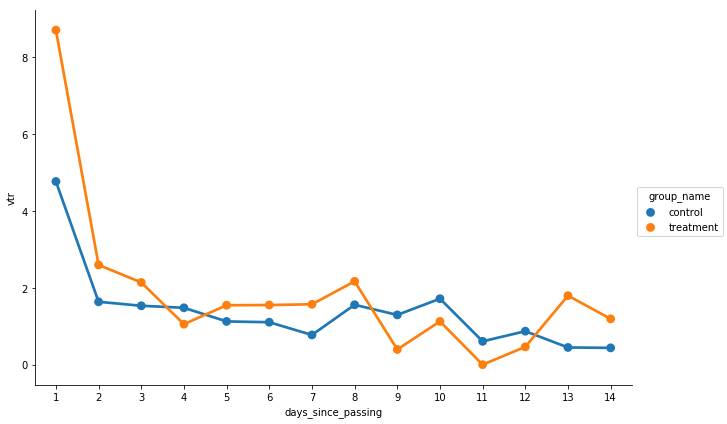

In [71]:
sns.factorplot(
    data = agg2_data_set,
    x = 'days_since_passing',
    y = 'vtr',
    hue = 'group_name',
    size = 6,
    aspect = 1.5,
)

In [72]:
# example of inline filtering
# * * *
# data_set_unaggregated[data_set_unaggregated['days_since_passing']<5]

In [73]:
# Unaggregated data set for testing statistical significance

In [74]:
%%vertica (analysis_end_time=analysis_end_time,analysis_start_time=analysis_start_time) -> data_set_unaggregated
select group_name, DATEDIFF('day',completed.passed_timestamp,:analysis_start_time) AS 'days_since_passing',
                        CASE
                        WHEN course.first_verified_enrollment_time > :analysis_start_time
                           AND course.first_verified_enrollment_time < :analysis_end_time
                           AND course.current_enrollment_mode = 'verified'
                        THEN 1
                        ELSE 0 
                        END
                        AS Verified
from neem.pal_experiment_population as pop
    INNER JOIN
    business_intelligence.course_master as master
        ON pop.course_id = master.course_id
    INNER JOIN 
        production.d_user_course as course
        ON pop.user_id = course.user_id
        AND pop.course_id = course.course_id
    INNER JOIN
        business_intelligence.course_completion_user as completed
    ON pop.user_id = completed.user_id
    AND pop.course_id = completed.course_id

In [75]:
#Example of in-line filtering 
#data_set_unaggregated[data_set_unaggregated['days_since_passing']<=3].head()

In [76]:
data_set_unaggregated.head()

,group_name,days_since_passing,Verified
0,treatment,4,0
1,treatment,14,0
2,control,14,0
3,treatment,3,0
4,treatment,14,0


In [77]:
import edx_stats

experiment_conf_intervals = edx_stats.grouped_confidence_intervals(
    #data_set_unaggregated[data_set_unaggregated['days_since_passing']<=3].reset_index(),
    data_set_unaggregated.reset_index(),
    variant_col='group_name',
    value_col='Verified',
    ctrl_name='control',
    group_cols=[]
)

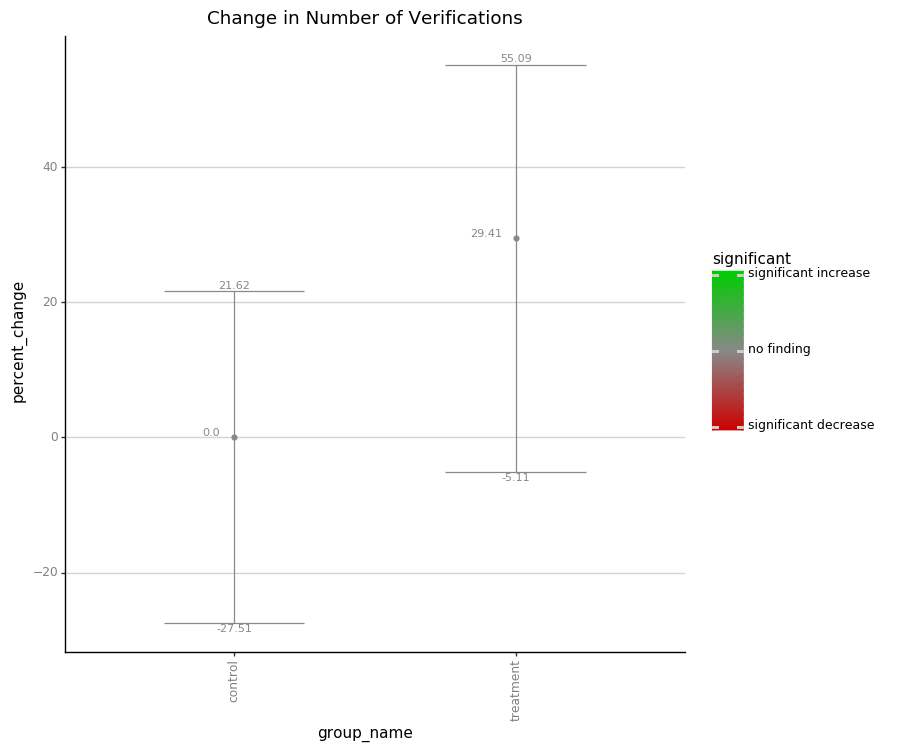

<ggplot: (8765947947142)>

In [78]:
from plotnine import *
from edx_plot import geom_confidence, theme_confidence
(
    ggplot(experiment_conf_intervals.reset_index(), aes(
        x='group_name',
        y='percent_change',
        ymin='lower_bound',
        ymax='upper_bound',
        color='significant',
        label_size=0.5,
    ))
    + geom_confidence()
    + theme_confidence()
    + ggtitle("Change in Number of Verifications")
)